In [1]:
pip install scikit-image==0.19.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 68.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.21.0
    Uninstalling scikit-image-0.21.0:
      Successfully uninstalled scikit-image-0.21.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2
import os
import json

from skimage.util import montage
from skimage.segmentation import mark_boundaries
from skimage.morphology import label
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import gc; gc.enable()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [80]:
#GlobalVariables

BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 500
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 20
MAX_TRAIN_EPOCHS = 20
AUGMENT_BRIGHTNESS = False
WEIGHT_DECAY = 1e-5

In [5]:
ship_dir = '/kaggle/input/airbus-ship-detection'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

In [6]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

Getting labels

In [7]:
lables = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_v2.csv'))

In [8]:
lables.describe()

,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


In [9]:
lables.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [10]:
print(f"Number of pictures: {len(lables['ImageId'].unique())}")
print(f"Images with at least one label: {len(lables['ImageId'].unique())-lables['EncodedPixels'].isnull().sum()}")
print(f"Total number of labels: {len(lables['EncodedPixels'])-lables['EncodedPixels'].isnull().sum()}")

Number of pictures: 192556
Images with at least one label: 42556
Total number of labels: 81723


Analyzing images sizes

In [11]:
#img_sizes = []
#img_names = []
#for i in os.listdir(train_image_dir):
    #img_names.append(i)
    #img_sizes.append(cv2.imread(train_image_dir+"/"+i).shape)

In [12]:
#img_names = np.array(img_names)
#img_shapes = np.array(img_sizes)

In [13]:
#img_sizes=img_shapes[:,:2]
#print(f"Image shape:{img_sizes[0]}")

In [14]:
#plt.plot(img_sizes)

All images are the same size, images do not require reshape

In [15]:
def mask_decoder(lable, shape = (768, 768)):
    splited = lable.split()
    starts, lengths = [np.asarray(x, dtype=np.longlong) for x in (splited[0:][::2], splited[1:][::2])]
    starts -=1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for low, high in zip(starts, ends):
        img[low:high] = 1
    return img.reshape(shape).T

In [16]:
def combine_masks(mask_list):
    masks = np.zeros((768,768), dtype=np.int32)
    for mask in mask_list:
        if isinstance(mask, str):
            masks += mask_decoder(mask)
    return np.expand_dims(masks, -1)

In [17]:
def mask_encoder(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:]!=pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [18]:
def multi_mask_encoder(img):
    labels = label(img[:, :, 0])
    return [mask_encoder(labels==k) for k in np.unique(labels[labels>0])]

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


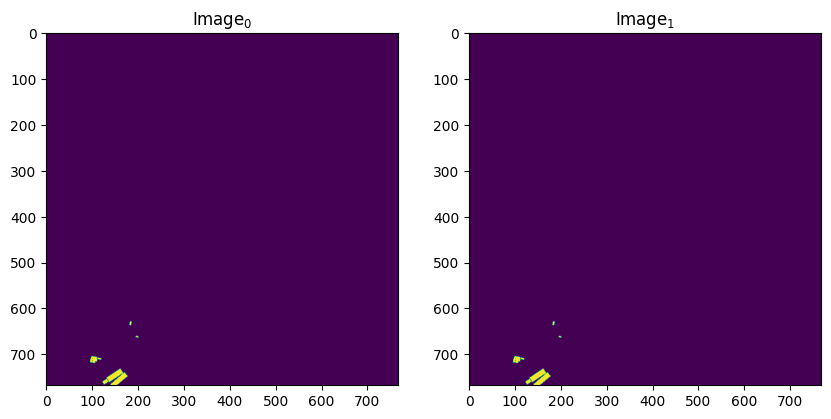

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = lables.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = combine_masks(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_mask_encoder(img_0)
img_1 = combine_masks(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
38743,339f7e521.jpg,0,0.0,[0.0],153.973633
14938,13d0122cd.jpg,1,1.0,[1.0],148.500000
67157,59631ecc6.jpg,0,0.0,[0.0],148.100586
46181,3d997b064.jpg,0,0.0,[0.0],93.520508
180983,f0b485e55.jpg,1,1.0,[1.0],180.448242


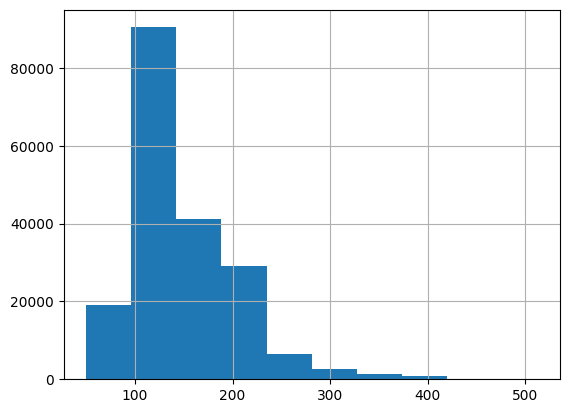

In [20]:
lables['ships'] = lables['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = lables.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)

unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
lables.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [36]:
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(lables, train_ids)
valid_df = pd.merge(lables, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


161048 training masks
69034 validation masks


<Axes: >

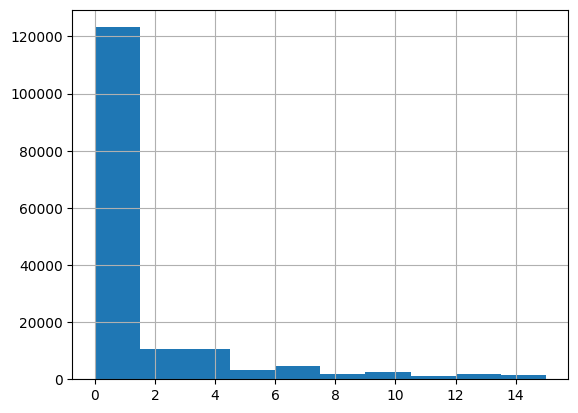

In [37]:
train_df['ships'].hist()

<Axes: >

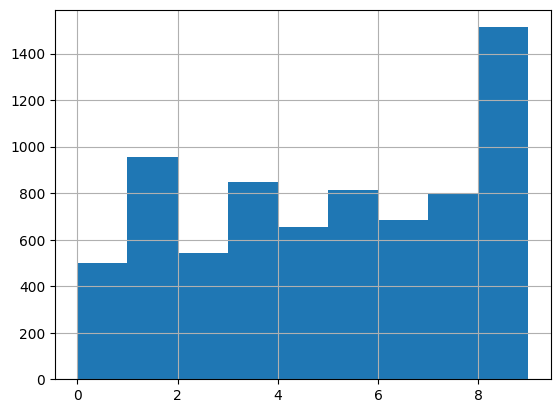

In [38]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))

In [39]:
def batch_image_gen(in_df, batch_size=BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = cv2.imread(rgb_path)
            c_mask = combine_masks(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [40]:
train_gen = batch_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1


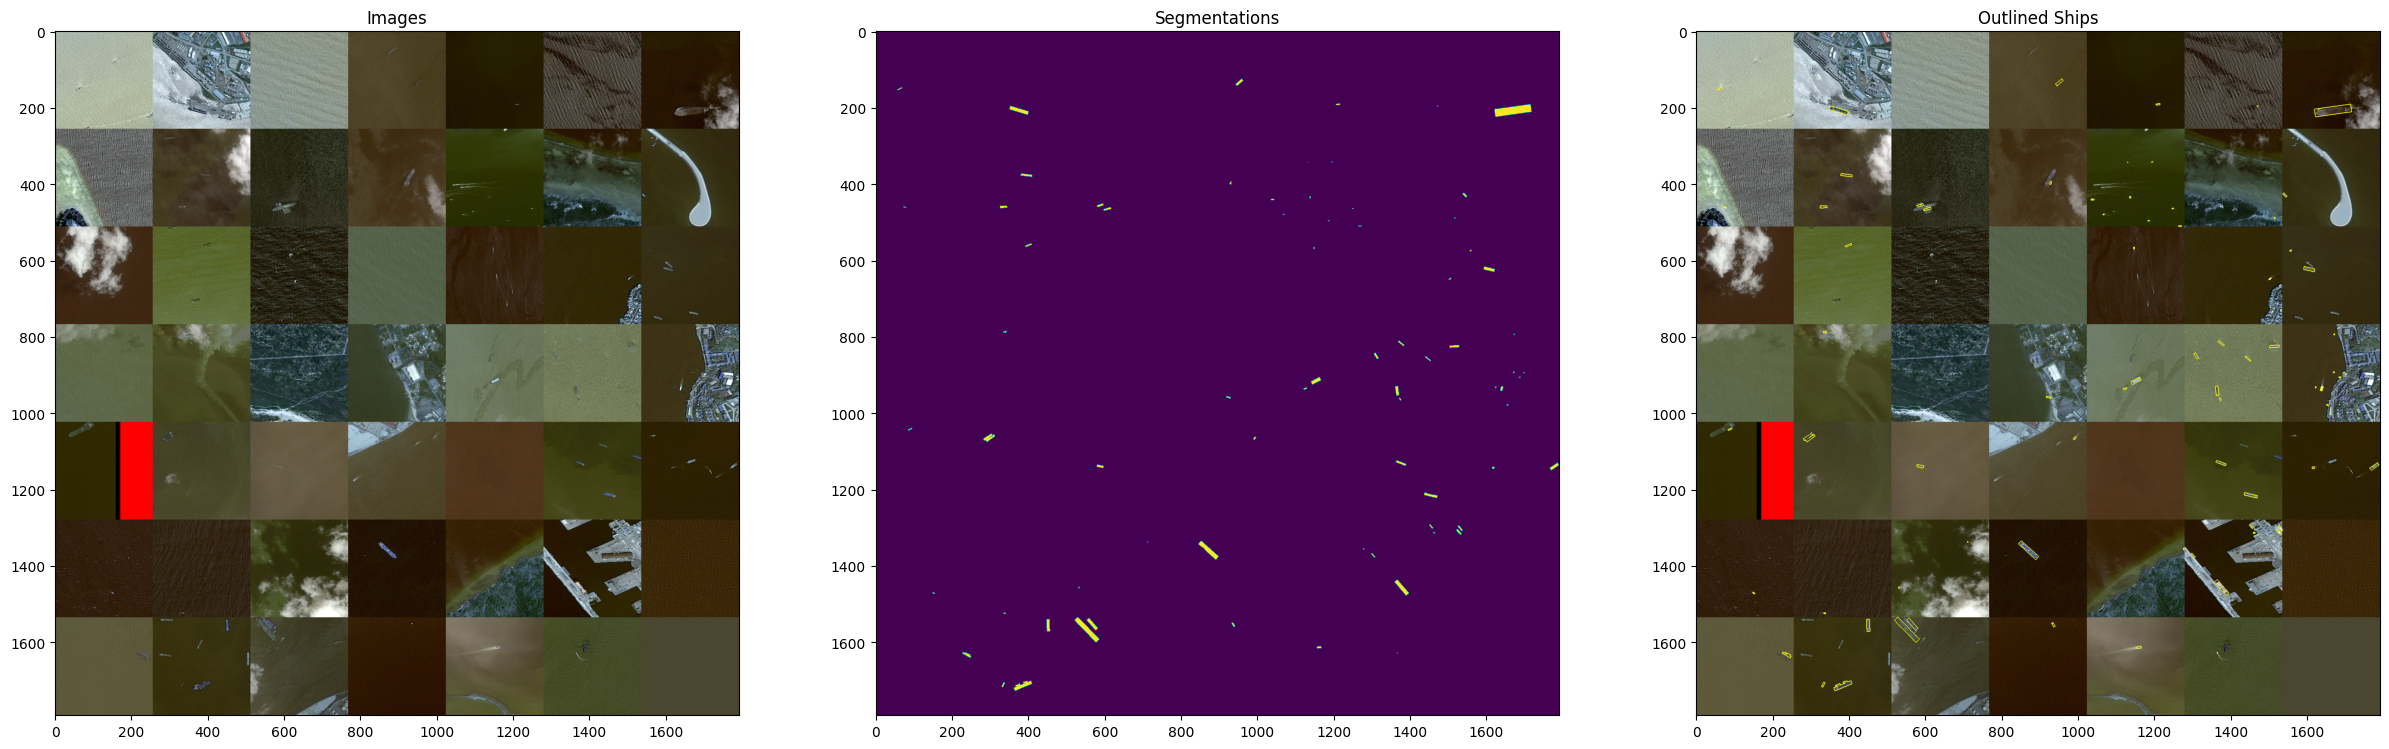

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int),
                           mode='thick'))
ax3.set_title('Outlined Ships')
fig.savefig('results/overview.png')

In [42]:
valid_x, valid_y = next(batch_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(500, 256, 256, 3) (500, 256, 256, 1)


In [43]:
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


Text(0.5, 1.0, 'ships')

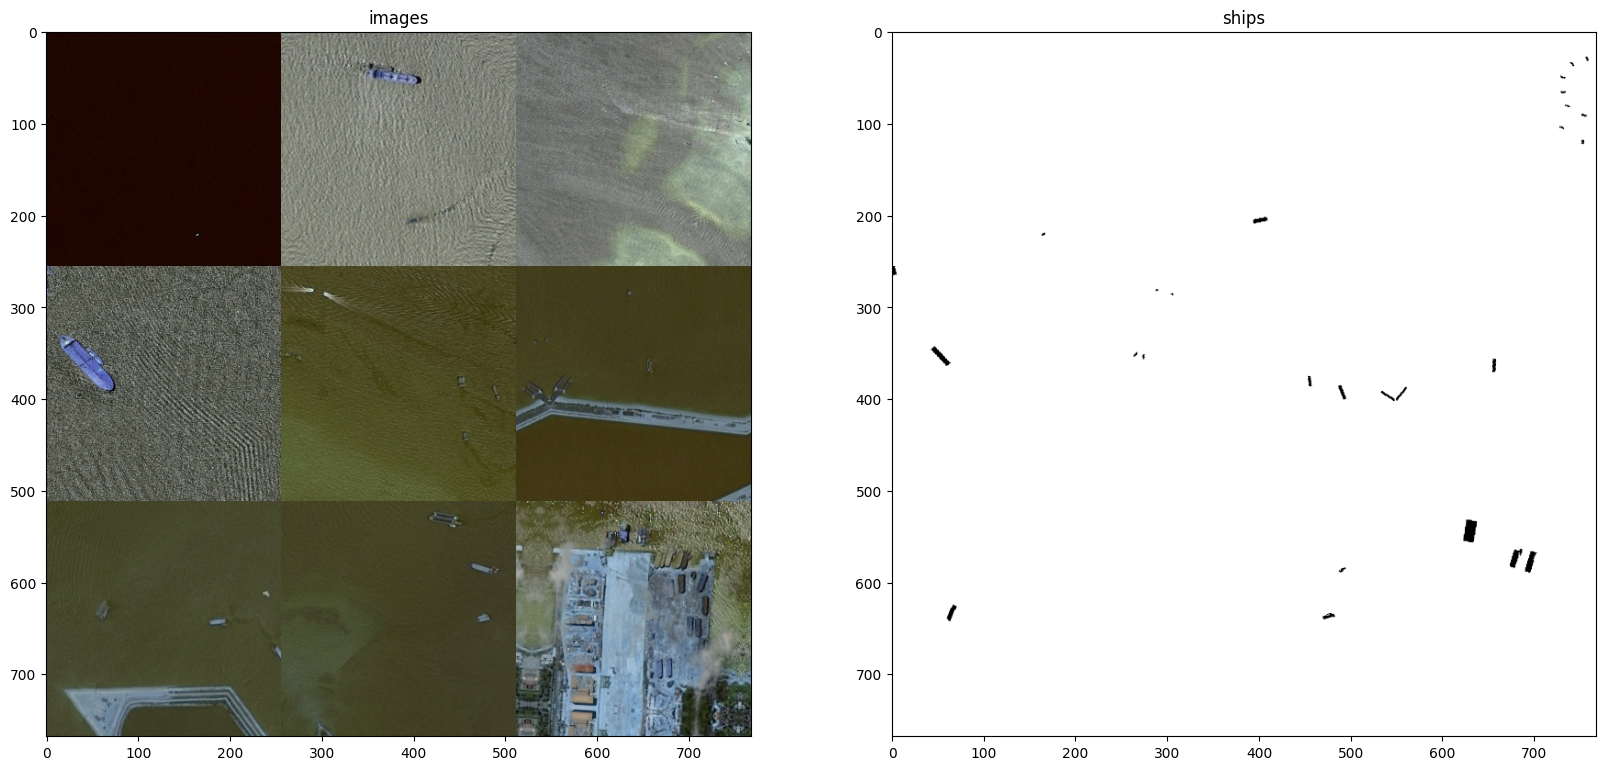

In [44]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [45]:
gc.collect()

75

Model building

In [72]:
w_decay = 1e-3

In [81]:
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(32, (3, 3), activation='leaky_relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (pp_in_layer)
c1 = layers.Conv2D(32, (3, 3), activation='leaky_relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)
p1 = layers.BatchNormalization()(p1)

c2 = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (p1)
c2 = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)
p2 = layers.BatchNormalization()(p2)

c3 = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (p2)
c3 = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)
p3 = layers.BatchNormalization()(p3)

c4 = layers.Conv2D(256, (3, 3), activation='leaky_relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (p3)
c4 = layers.Conv2D(256, (3, 3), activation='leaky_relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = layers.BatchNormalization()(p4)


c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (p4)
c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (c5)

u6 = upsample(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (u6)
c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (c6)

u7 = upsample(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (u7)
c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (c7)

u8 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (u8)
c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (c8)

u9 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (u9)
c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY)) (c9)
# d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
# d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)
seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 average_pooling2d_6 (Avera  (None, 256, 256, 3)          0         ['RGB_Input[0][0]']           
 gePooling2D)                                                                                     
                                                                                                  
 gaussian_noise_6 (Gaussian  (None, 256, 256, 3)          0         ['average_pooling2d_6[0][0]'] 
 Noise)                                                                                           
                                                                                            

In [84]:
@tf.function
def dice_coef(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score
@tf.function
def dice_p_bce(in_gt, in_pred):
    return - dice_coef(in_gt, in_pred)
@tf.function
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-3), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [85]:
weight_path="results/{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                                   patience=3, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=20) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [86]:
def fit():
    seg_model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_p_bce, metrics=[dice_coef, true_positive_rate])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(batch_image_gen(train_df))
    loss_history = [seg_model.fit_generator(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]
    return loss_history

while True:
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < 0.01:
        break

/tmp/ipykernel_42/394609452.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = [seg_model.fit_generator(aug_gen,


Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.0224 - dice_coef: 0.0022 - true_positive_rate: 0.8123
Epoch 1: val_loss improved from inf to 0.01685, saving model to seg_model_weights.best.hdf5
20/20 [==============================] - 44s 2s/step - loss: 0.0224 - dice_coef: 0.0022 - true_positive_rate: 0.8123 - val_loss: 0.0168 - val_dice_coef: 0.0027 - val_true_positive_rate: 0.9989 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.0131 - dice_coef: 0.0019 - true_positive_rate: 0.9999
Epoch 2: val_loss improved from 0.01685 to 0.00795, saving model to seg_model_weights.best.hdf5
20/20 [==============================] - 33s 2s/step - loss: 0.0131 - dice_coef: 0.0019 - true_positive_rate: 0.9999 - val_loss: 0.0080 - val_dice_coef: 0.0027 - val_true_positive_rate: 0.9991 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.0018 - dice_coef: 0.0062 - true_positive_rate: 0.6759
Epoch 3: val_loss improved f

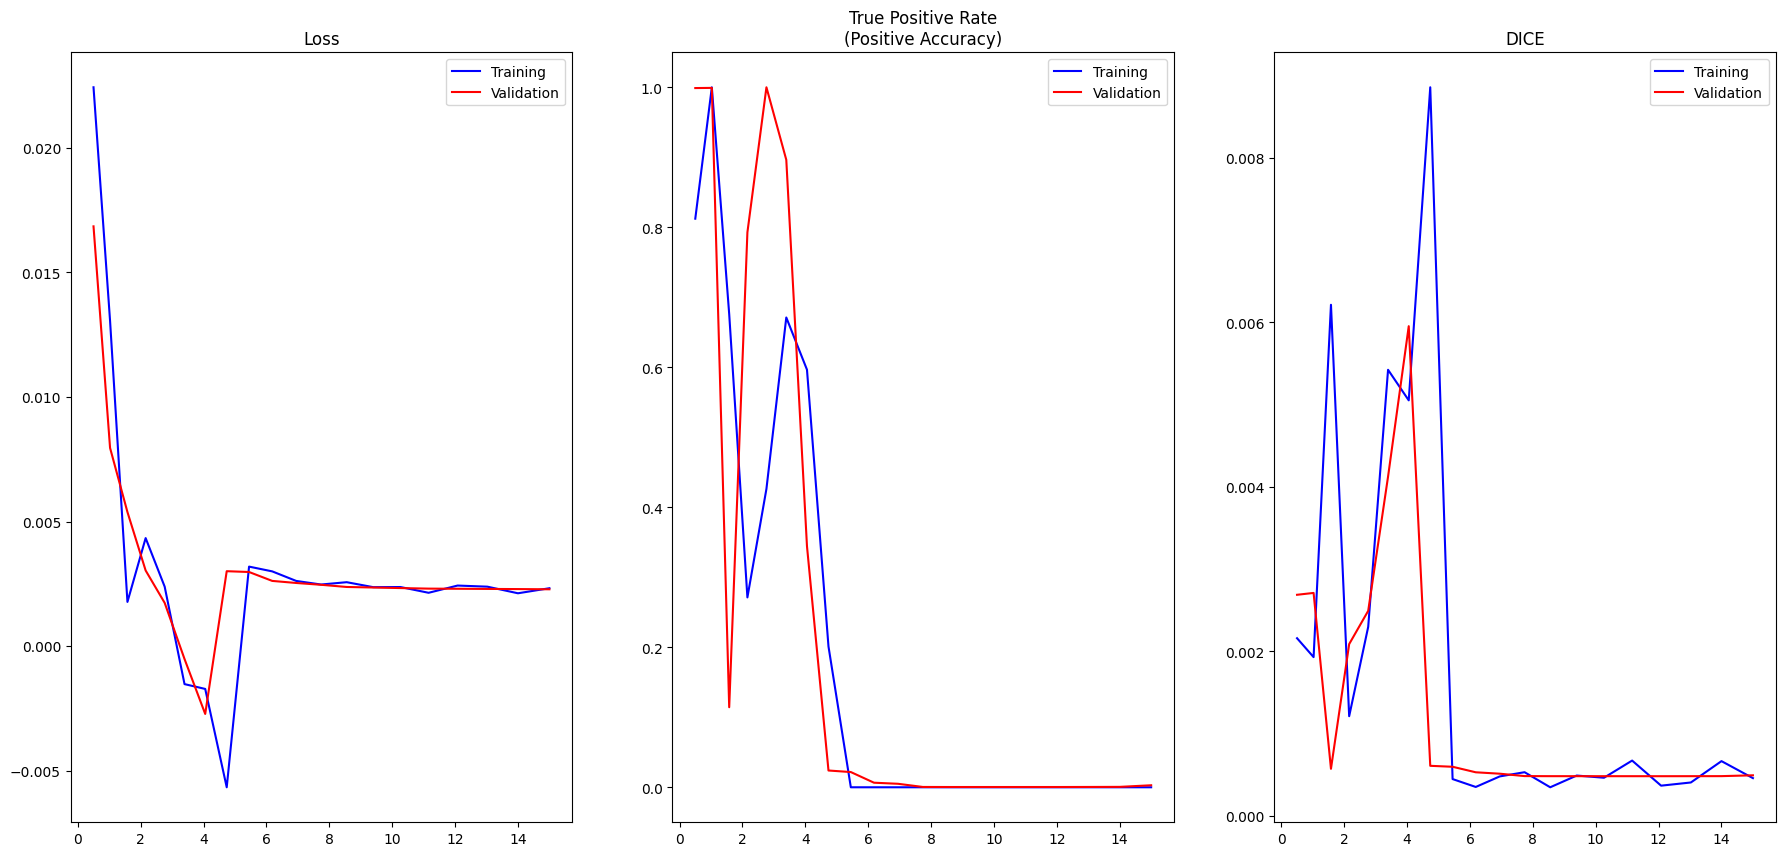

In [88]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('DICE')

show_loss(loss_history)

In [89]:
seg_model.load_weights(weight_path)
seg_model.save('results/seg_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [90]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

16/16 [==============================] - 2s 94ms/step
(500, 256, 256, 1) 0.0 1.0 0.14768401


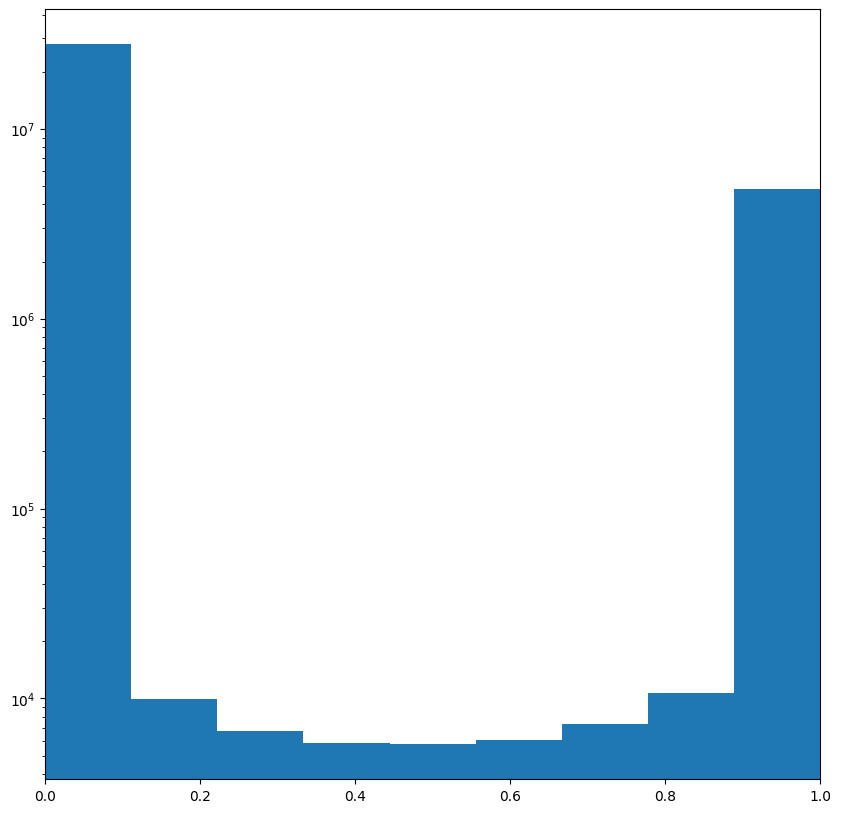

In [92]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log')

In [93]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('results/fullres_model.h5')

In [94]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

15606 test images found


1/1 [==============================] - 0s 22ms/step


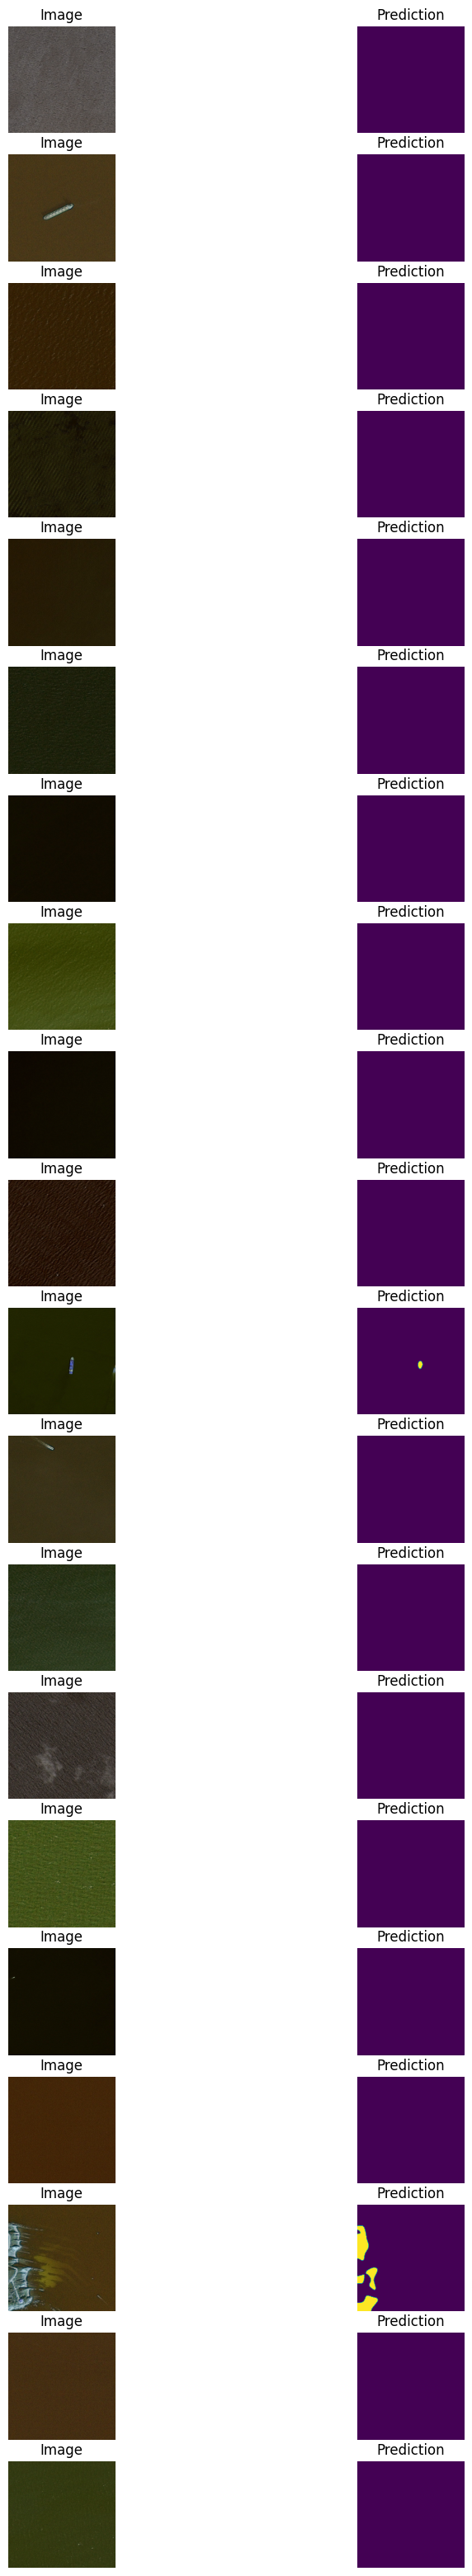

In [97]:
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = cv2.imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('results/test_predictions.png')